# Step 4: Scoring the Reconstruction

Notebook Code: [![License: MIT](https://img.shields.io/badge/License-GPLv3-blue.svg)](https://www.gnu.org/licenses/gpl-3.0) Notebook Prose: [![License: CC BY 4.0](https://img.shields.io/badge/License-CC_BY_4.0-lightgrey.svg)](https://creativecommons.org/licenses/by/4.0/)

---

After estimation and subtraction of the baseline, detection of peaks, splitting into windows, and fitting
the peaks to a phenomenological function, we are left with the irritating problem 
of assessing how well we have done. Consider the following chromatogram:

Deconvolving mixture: 100%|██████████| 2/2 [00:00<00:00,  7.70it/s]


[<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='time_min', ylabel='intensity_mV (baseline corrected)'>]

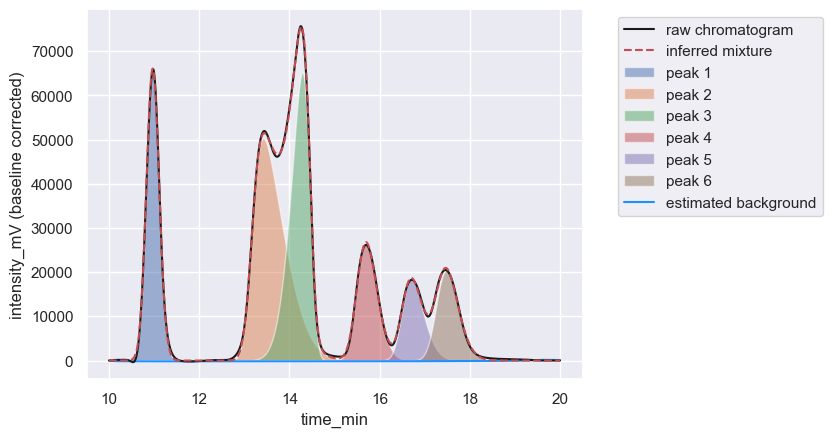

In [4]:
from hplc.quant import Chromatogram
import pandas as pd 

# Load the sample chromatogram and fit the peaks using default parameters.
df = pd.read_csv('data/sample_chromatogram.txt')
chrom = Chromatogram(df, cols={'time':'time_min', 'signal':'intensity_mV'}, 
                     time_window=[10, 20])
peaks = chrom.fit_peaks()
chrom.show()

By eye, this looks like a very good reconstruction of the chromatogram, but 
it would be nice to have a quantitative measure. 

## The Reconstruction Score
Quantifying concentrations from HPLC data requires a measure of the **A**rea **U**nder
the **C**urve (AUC), or more correctly stated, the integrated signal over a 
given time interval.  A perfect reconstruction of the chromatogram, resulting from 
summing over all constituent peaks in a mixture, would yield an identical AUC
over any given time interval as the integrated signal of the original chromatogram. 
This can be defined mathematically as 
$$
\frac{\sum\limits_i^{N_\text{peaks}} \sum\limits_{t=0}^{t_\text{max}}S_i(t)}{\sum\limits_{t=0}^{t_\text{max}}S(t)^\text{(observed)}} = \frac{\text{AUC}^\text{(inferred)}}{\text{AUC}^\text{(observed)}} = 1, \tag{1}
$$
where $i$ represents the $i$-th component signal, $N_\text{peaks}$ denotes the number of 
peaks in a given peak window, and $t$ denotes the discrete time point.
In peak windows where the constituent signal is very small $S_{i}^\text{(observed)} \rightarrow 0$,
even small deviations between the inferred mixture and the observed signal can cause 
this quantity to be much larger or much smaller than one, even if the total integrated 
signal difference is small. 

To account for this fact, we can modify Eq. 1 as 

$$
R = \frac{1 + \text{AUC}^\text{(inferred)}}{1 + \text{AUC}^{(observed)}}, \tag{2}
$$
which we term a *reconstruction score* or $R$-score for short. 

In practice, you'll never get an $R$-score of exactly 1, but you can get close. 
For example, an $R$-score can be computed for the chromatogram reconstruction 
shown above by calling the `_score_reconstruction` method of a `Chromatogram` object:

In [8]:
# Compute the R_score for the above chromatogram
scores = chrom._score_reconstruction()
scores[['window_type', 'window_id', 'reconstruction_score']]

,window_type,window_id,reconstruction_score
0,peak,1,0.997248
1,peak,2,0.994906
0,interpeak,1,0.383445
1,interpeak,2,0.000200
2,interpeak,3,0.079104


For the two peak windows (rows 1 & 2), the $R$-score is very close to one, within 0.01.
Whether that is sufficient for your case or not is up to you, dear reader. My job is just 
to give you that number. 

## Scoring the regions between peaks
But what about the interpeak regions? These windows correspond to the chromatogram 
signal that lies outside of peak windows -- thus, an $R$-score is a measure of 
how well you are reconstructing the subtracted baseline. As there will almost always 
be 0 inferred signal in this region, your $R$-scores will typically be terrible and 
close to 0. 

While this will *usually* mean you are just not reconstructing the signal noise, 
a terrible $R$-score in an interpeak region may mean that there are peaks present, 
but your choice of a prominence filter is not detecting them. In this case, 
it is better to have a measure of what the noise-to-signal ratio is in these regions. 

Mathematically, we can compute this as the [Fano factor](https://en.wikipedia.org/wiki/Fano_factor) of the region,
which can be thought of as a measure of the "predictability" of the signal in this 
sequence. This can be computed as 

$$
F = \frac{\langle S^2 \rangle - \langle S \rangle^2}{\langle S \rangle}, \tag{3}
$$
where $S$ is the signal within a peak window. If the Fano factor is small, then 
the region is likely background noise whereas a large Fano factor would indicate 
there may be a peak present and you need to adjust your peak detection criteria. 

But what determines if it's big or small? As all chromatograms have a peak (why 
else would you be using `hplc-py`?), we can compare the Fano factor of the interpeak 
regions  to the average Fano factors of the regions where we know there is signal. 
If this quantity, which term the *Fano ratio*, is close to zero, then it is likely 
the interpeak region is just noise and you are not missing anything substantive. However,
if the Fano ratio is *not* close to zero, there may be a peak present. Again, 
what determines "close" to zero is arbitrary. 


## Generating a chromatogram report card
In `hplc-py`, you can automatically generate "report" cards by calling the 
`assess_fit` method of a Chromatogram object. For the chromatogram above, the
report card looks pretty good!

In [11]:
# Generate a report card with the default tolerances
scores = chrom.assess_fit()


-------------------Chromatogram Reconstruction Report Card----------------------

Reconstruction of Peaks

A+, Success:  Peak Window 1 (t: 10.558 - 11.758) R-Score = 0.9972
A+, Success:  Peak Window 2 (t: 12.117 - 19.817) R-Score = 0.9949

Signal Reconstruction of Interpeak Windows
                  
C-, Needs Review:  Interpeak Window 1 (t: 10.000 - 10.550) R-Score = 0.3834 & Fano Ratio = 0.0023
Interpeak window 1 is not well reconstructed by mixture, but has a small Fano factor  
compared to peak region(s). This is likely acceptable, but visually check this region.

C-, Needs Review:  Interpeak Window 2 (t: 11.767 - 12.108) R-Score = 10^-3 & Fano Ratio = 0.0012
Interpeak window 2 is not well reconstructed by mixture, but has a small Fano factor  
compared to peak region(s). This is likely acceptable, but visually check this region.

C-, Needs Review:  Interpeak Window 3 (t: 19.825 - 20.000) R-Score = 10^-1 & Fano Ratio = 0.0000
Interpeak window 3 is not well reconstructed by mixture

This report card is telling you that the two peak windows seem to be really well 
reconstructed, whereas the interpeak regions *may* be poorly reconstructed and 
you should take a look.  If you have a sense of what the relative tolerances 
should be (meaning, you have made a subjective decision of how close or far from 1.0
you deem to be successful), you can pass different tolerances to `assess_fit`.


In [16]:
# Assess the fit, but with different tolerances.
scores = chrom.assess_fit(rtol=1E-3)


-------------------Chromatogram Reconstruction Report Card----------------------

Reconstruction of Peaks

F, Failed:  Peak Window 1 (t: 10.558 - 11.758) R-Score = 0.9972
Peak mixture poorly reconstructs signal. You many need to adjust parameter bounds 
or add manual peak positions (if you have a shouldered pair, for example). If 
you have a very noisy signal, you may need to increase the reconstruction 
tolerance `rtol`.
F, Failed:  Peak Window 2 (t: 12.117 - 19.817) R-Score = 0.9949
Peak mixture poorly reconstructs signal. You many need to adjust parameter bounds 
or add manual peak positions (if you have a shouldered pair, for example). If 
you have a very noisy signal, you may need to increase the reconstruction 
tolerance `rtol`.

Signal Reconstruction of Interpeak Windows
                  
C-, Needs Review:  Interpeak Window 1 (t: 10.000 - 10.550) R-Score = 0.3834 & Fano Ratio = 0.0023
Interpeak window 1 is not well reconstructed by mixture, but has a small Fano factor  
compar

In either case, `assess_fit` will still print out the $R$-scores and Fano ratios 
for you to make your own call on what is good or bad. 

## Assessing the fit ≠ computing uncertainty 

If you take one thing away from this page, please let it be that an $R$-score 
is **not** a measure of the uncertainty in your reconstruction. It is solely 
to be used as discriminator for you to make a judgement call of whether 
you are properly reconstructing the signal.



---

<small> © Griffin Chure, 2023. This notebook and the code within are released under a 
[Creative-Commons CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/) and 
[GPLv3](https://www.gnu.org/licenses/gpl-3.0) license, respectively.</small>
